# Pitchfork Data

I will be examining [this SQLite database](https://www.kaggle.com/nolanbconaway/pitchfork-data) that a Kaggle user scraped from Pitchfork.com that includes info about all the records they have reviewed as recently as 2017. I am using the sqlite3 module to access the database in this notebook. For more info, check out [this article](https://datacarpentry.org/python-ecology-lesson/09-working-with-sql/index.html) for a good overview of sqlite3 module's basic functionality. 

## Importing Data

In [2]:
import sqlite3

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Here's a breakdown of the tables and columns from the pitchfork database.

#### Tables:
* artists
    * reviewid
    * artist
* content
    * reviewid
    * content
* genres
    * reviewid
    * genre
* labels
    * reviewid
    * label
* reviews
    * reviewid
    * title
    * artist
    * url
    * score 
    * best_new_music
    * author
    * author_type
    * pub_date
    * pub_weekday
    * pub_day
    * pub_month
    * pub_year
* years
    * reviewid
    * year

## How to use sqlite3

In [3]:
# Create a SQL connection to our SQLite database

con = sqlite3.connect('data/database.sqlite')
cur = con.cursor()

In [4]:
# The result of a "cursor.execute" can be iterated over by row

for row in cur.execute('SELECT * FROM reviews LIMIT 2;'):
    print(row)

(22703, 'mezzanine', 'massive attack', 'http://pitchfork.com/reviews/albums/22703-mezzanine/', 9.3, 0, 'nate patrin', 'contributor', '2017-01-08', 6, 8, 1, 2017)
(22721, 'prelapsarian', 'krallice', 'http://pitchfork.com/reviews/albums/22721-prelapsarian/', 7.9, 0, 'zoe camp', 'contributor', '2017-01-07', 5, 7, 1, 2017)


In [5]:
# Return FIRST result of query AS TUPLE

cur.execute('SELECT * FROM reviews WHERE score>7')
test_query1 = cur.fetchone()

print(len(test_query1))    # this row of data has 13 columns
print(type(test_query1))


13
<class 'tuple'>


In [6]:
# Return ALL results of query AS LIST

cur.execute("SELECT * FROM reviews WHERE score>7")
test_query2 = cur.fetchall()

print(len(test_query2))    # list of tuples, one tuple for each row
print(type(test_query2))

10315
<class 'list'>


In [7]:
# Return ALL results of query AS DATAFRAME

test_query2 = pd.read_sql_query("SELECT * FROM reviews WHERE score>7", con) # con is connection object established earlier

print(len(test_query2))    # each row as row in df
print(type(test_query2))

10315
<class 'pandas.core.frame.DataFrame'>


In [8]:
test_query2.head(3)

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017


In [9]:
# Be sure to close the connection

con.close()

## EDA

In [10]:
# Create a SQL connection to our SQLite database

con = sqlite3.connect('data/database.sqlite')
cur = con.cursor()

In [11]:
review_df = pd.read_sql_query("SELECT * FROM reviews", con, parse_dates={'pub_date':'%Y-%m-%d'})

In [12]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   reviewid        18393 non-null  int64         
 1   title           18393 non-null  object        
 2   artist          18393 non-null  object        
 3   url             18393 non-null  object        
 4   score           18393 non-null  float64       
 5   best_new_music  18393 non-null  int64         
 6   author          18393 non-null  object        
 7   author_type     14487 non-null  object        
 8   pub_date        18393 non-null  datetime64[ns]
 9   pub_weekday     18393 non-null  int64         
 10  pub_day         18393 non-null  int64         
 11  pub_month       18393 non-null  int64         
 12  pub_year        18393 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(5)
memory usage: 1.8+ MB


In [13]:
review_df.describe()

,reviewid,score,best_new_music,pub_weekday,pub_day,pub_month,pub_year
count,18393.000000,18393.000000,18393.000000,18393.000000,18393.000000,18393.000000,18393.000000
mean,12344.876529,7.005779,0.051270,2.106508,15.529006,6.283532,2008.678465
std,6318.857619,1.293675,0.220553,1.635406,8.757538,3.317349,4.626094
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1999.000000
25%,7445.000000,6.400000,0.000000,1.000000,8.000000,3.000000,2005.000000
50%,12804.000000,7.200000,0.000000,2.000000,15.000000,6.000000,2009.000000
75%,17658.000000,7.800000,0.000000,3.000000,23.000000,9.000000,2013.000000
max,22745.000000,10.000000,1.000000,6.000000,31.000000,12.000000,2017.000000


In [14]:
# getting total reviews per year

annual_reviews = pd.read_sql_query("SELECT pub_year, \
                                        count(reviewid) AS total_annual_reviews, \
                                        AVG(score) AS mean_yearly_score \
                                        FROM reviews \
                                        GROUP BY pub_year \
                                        ORDER BY pub_year ASC", con, parse_dates={'pub_date':'%Y-%m-%d'})

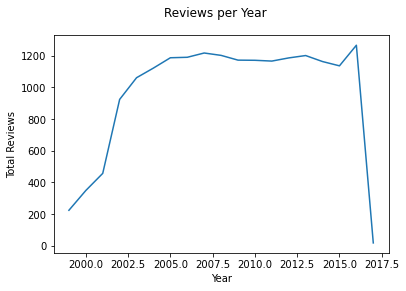

In [15]:
# plotting reviews for each year

sns.lineplot(annual_reviews.pub_year, annual_reviews.total_annual_reviews)
plt.suptitle('Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Total Reviews');

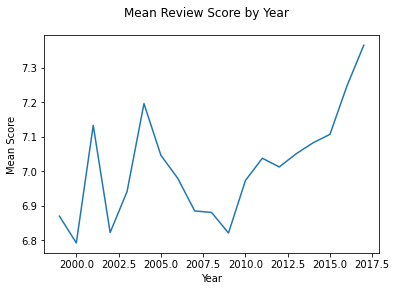

In [16]:
sns.lineplot(annual_reviews.pub_year, annual_reviews.mean_yearly_score)
plt.suptitle('Mean Review Score by Year')
plt.xlabel('Year')
plt.ylabel('Mean Score');

In [17]:
# OVERALL mean score and total review count for each genre


genres_df = pd.read_sql_query("SELECT DISTINCT genres.genre, \
                                count(genres.reviewid) as total_reviews_per_genre, \
                                AVG(reviews.score) as mean_score_by_genre \
                                FROM genres  \
                                JOIN reviews ON genres.reviewid = reviews.reviewid \
                                GROUP BY genre \
                                ORDER BY count(genres.reviewid) DESC", con)

In [18]:
genres_df

,genre,total_reviews_per_genre,mean_score_by_genre
0,rock,9438,6.942011
1,electronic,3874,6.920702
2,None,2371,7.017925
3,experimental,1815,7.336694
4,rap,1559,6.900513
5,pop/r&b,1432,6.883799
6,metal,862,6.950000
7,folk/country,685,7.202190
8,jazz,435,7.303908
9,global,219,7.429680


In [19]:
# ANNUAL mean score and total review count for each genre

genres_years_df1 = pd.read_sql_query("SELECT genres.genre, reviews.pub_year, \
                                AVG(reviews.score) as genre_year_avg_score, \
                                count(reviews.reviewid) as  genre_year_total_reviews \
                                FROM reviews INNER JOIN genres ON genres.reviewid=reviews.reviewid \
                                WHERE genres.genre IS NOT NULL \
                                GROUP BY genres.genre, reviews.pub_year \
                                ORDER BY genre, pub_year", con)

In [20]:
genres_years_df1

,genre,pub_year,genre_year_avg_score,genre_year_total_reviews
0,electronic,1999,6.797101,69
1,electronic,2000,7.120000,80
2,electronic,2001,6.923232,99
3,electronic,2002,6.958947,190
4,electronic,2003,6.863158,266
...,...,...,...,...
162,rock,2013,7.017184,483
163,rock,2014,7.061165,412
164,rock,2015,6.969565,437
165,rock,2016,7.282217,433


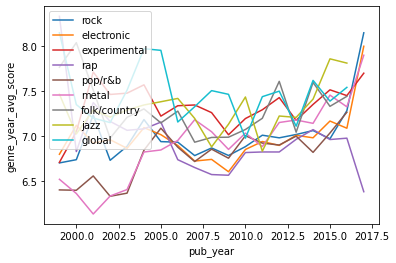

In [21]:
# extremely messy viz of genre ratings over the years

for x in genres_df.genre:
    sns.lineplot(genres_years_df1[genres_years_df1.genre==x].pub_year, genres_years_df1.genre_year_avg_score, label=x)

In [22]:
# top reviewed genre for each year

total_reviews_genre_year = []

for i in range(1999, 2018):
    query = ("SELECT reviews.pub_year, genres.genre, \
                                    AVG(reviews.score) as genre_year_avg_score, \
                                    COUNT(reviews.reviewid) as genre_year_total_reviews \
                                    FROM reviews INNER JOIN genres ON genres.reviewid=reviews.reviewid \
                                    WHERE genres.genre IS NOT NULL AND pub_year IS {} \
                                    GROUP BY reviews.pub_year, genres.genre \
                                    ORDER BY genre_year_total_reviews DESC \
                                    LIMIT 1".format(i))
    
    yearly_df = pd.read_sql_query(query, con)
    
    total_reviews_genre_year.append([i, yearly_df.genre[0]])

total_reviews_genre_year

[[1999, 'rock'],
 [2000, 'rock'],
 [2001, 'rock'],
 [2002, 'rock'],
 [2003, 'rock'],
 [2004, 'rock'],
 [2005, 'rock'],
 [2006, 'rock'],
 [2007, 'rock'],
 [2008, 'rock'],
 [2009, 'rock'],
 [2010, 'rock'],
 [2011, 'rock'],
 [2012, 'rock'],
 [2013, 'rock'],
 [2014, 'rock'],
 [2015, 'rock'],
 [2016, 'rock'],
 [2017, 'rap']]

In [23]:
main_df_raw = pd.read_sql_query(("SELECT DISTINCT reviews.score,  reviews.artist, reviews.title, \
                        reviews.best_new_music, reviews.pub_date, reviews.pub_year, \
                        years.year, genres.genre, labels.label, reviews.author, reviews.reviewid\
                        FROM reviews \
                        INNER JOIN genres ON reviews.reviewid = genres.reviewid \
                        INNER JOIN years ON reviews.reviewid = years.reviewid \
                        INNER JOIN  labels ON reviews.reviewid = labels.reviewid \
                        GROUP BY reviews.reviewid"), 
                           con, 
                           #index_col='reviewid',
                           parse_dates={'reviews.pub_date':'%Y-%m-%d'})
len(main_df_raw)

18389

**Missing Data**

* GENRE missing for ~2k rows, impute with 'OTHER' for now. 

* YEAR is release year, PUB_YEAR is review year  

    * IMPUTE NAN YEAR with PUB_YEAR  
    
    * ENGINEER A FEATURE of diff btw YEAR & PUB_YEAR



* LABEL missing for a ~200 rows. May not even use this so DO NOTHING for now. 

In [24]:
main_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18389 entries, 0 to 18388
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score           18389 non-null  float64
 1   artist          18389 non-null  object 
 2   title           18389 non-null  object 
 3   best_new_music  18389 non-null  int64  
 4   pub_date        18389 non-null  object 
 5   pub_year        18389 non-null  int64  
 6   year            17983 non-null  float64
 7   genre           16024 non-null  object 
 8   label           18351 non-null  object 
 9   author          18389 non-null  object 
 10  reviewid        18389 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 1.5+ MB


In [25]:
# stats for all music combined

main_df_raw.describe()

,score,best_new_music,pub_year,year,reviewid
count,18389.000000,18389.000000,18389.000000,17983.000000,18389.000000
mean,7.005715,0.051281,2008.679047,2007.834010,12345.501822
std,1.293758,0.220576,4.626428,6.707638,6319.402584
min,0.000000,0.000000,1999.000000,1959.000000,1.000000
25%,6.400000,0.000000,2005.000000,2005.000000,7444.000000
50%,7.200000,0.000000,2009.000000,2008.000000,12806.000000
75%,7.800000,0.000000,2013.000000,2012.000000,17659.000000
max,10.000000,1.000000,2017.000000,2017.000000,22745.000000


In [26]:
# stats for BEST NEW MUSIC
# LOOK INTO WHY SOME BEST NEW MUSIC HAD VERY LOW SCORE (25% QUARTILE)

main_df_raw[main_df_raw.best_new_music == 1].describe()

,score,best_new_music,pub_year,year,reviewid
count,943.000000,943.0,943.000000,942.000000,943.000000
mean,8.676458,1.0,2010.702015,2006.801486,14868.567338
std,0.496161,0.0,3.792000,9.884986,5589.857177
min,3.500000,1.0,2003.000000,1959.000000,81.000000
25%,8.400000,1.0,2008.000000,2005.000000,12340.000000
50%,8.600000,1.0,2011.000000,2010.000000,15811.000000
75%,8.900000,1.0,2014.000000,2013.000000,19252.500000
max,10.000000,1.0,2017.000000,2016.000000,22745.000000


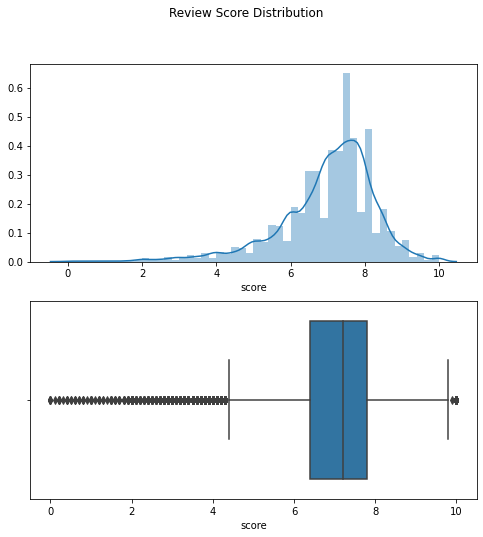

In [27]:
# examining dist of review scores

plt.figure(figsize=(8,8))
plt.suptitle('Review Score Distribution')
plt.subplot(2, 1, 1)
sns.distplot(main_df_raw.score)
plt.subplot(2, 1, 2)
sns.boxplot(main_df_raw.score);

# skewed left

In [28]:
# Closing the connection

con.close()

## Cleaning and Feature Engineering

### Saving raw df as csv

In [29]:
main_df_raw.to_csv('data/pitchfork_data_raw.csv')

### Making copy to clean

In [30]:
main_df_clean = main_df_raw

### Imputing null year values 

In [31]:
main_df_raw.iloc[122]

score                                       6.8
artist                          the anniversary
title             designing a nervous breakdown
best_new_music                                0
pub_date                             2000-01-25
pub_year                                   2000
year                                        NaN
genre                                      rock
label                                   vagrant
author                          taylor m. clark
reviewid                                    199
Name: 122, dtype: object

In [32]:
main_df_clean.year.fillna(main_df_clean.pub_year, inplace=True)

In [33]:
main_df_clean[main_df_clean.year.isnull()].head()

,score,artist,title,best_new_music,pub_date,pub_year,year,genre,label,author,reviewid


In [34]:
# null was imputed with pub_year

main_df_clean.iloc[122]

score                                       6.8
artist                          the anniversary
title             designing a nervous breakdown
best_new_music                                0
pub_date                             2000-01-25
pub_year                                   2000
year                                       2000
genre                                      rock
label                                   vagrant
author                          taylor m. clark
reviewid                                    199
Name: 122, dtype: object

### Adding column for release-publish year difference

In [35]:
main_df_clean['review_delay'] = main_df_clean.pub_year - main_df_clean.year

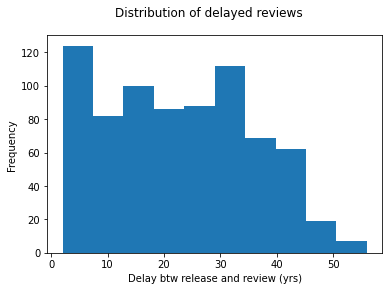

In [36]:
# visualizing review delay

plt.hist(main_df_clean[main_df_clean.review_delay > 1].review_delay)
plt.suptitle('Distribution of delayed reviews')
plt.xlabel('Delay btw release and review (yrs)')
plt.ylabel('Frequency')
plt.savefig('viz/release_delay.svg');

Not pictured: the majority of data where there was no delay between release and review.   

I chose delay > 1 year since some normally timed reviews fall on either side of the calendar year.


### Imputing missing genre

In [180]:
main_df_clean.genre.fillna('Other', inplace=True)

In [184]:
# number of 'other' genre albums

len(main_df_clean[main_df_clean.genre=='Other'])

2365

### Investigate missing label

In [188]:
len(main_df_clean[main_df_clean.label.isnull()])

38

In [199]:
main_df_clean[main_df_clean.label.isnull()].label.sample()

16327    None
Name: label, dtype: object

In [196]:
main_df_clean.iloc[13125]

score                          8
artist               joey bada$$
title                       1999
best_new_music                 0
pub_date              2012-06-26
pub_year                    2012
year                        2012
genre                        rap
label                       None
author            felipe delerme
reviewid                   16864
review_delay                   0
Name: 13125, dtype: object

After a brief investigation, I found that "None" here does not necessarily mean the artist was unsigned at the time of the release/review (Joey Bada$$ was signed to [Datpiff](https://pitchfork.com/reviews/albums/16864-1999/) for this mixtape)

### Renaming columns for readability

In [202]:
main_df_clean.columns

Index(['score', 'artist', 'title', 'best_new_music', 'pub_date', 'pub_year',
       'year', 'genre', 'label', 'author', 'reviewid', 'review_delay'],
      dtype='object')

In [207]:
main_df_clean.rename(columns={'title':'album_title', 
                              'author':'review_author', 
                              'score':'album_review_score', 
                              'year':'album_release_year', 
                              'pub_year':'review_pub_year', 
                              'genre':'album_genre', 
                              'pub_date':'review_pub_date'}, 
                     inplace=True)

### Adding Column to feed to Spotify API

Putting album title and artist in a format Spotify API can easily ingest

In [228]:
main_df_clean['api_formatted'] = main_df_clean.album_title + ', ' + main_df_clean.artist
main_df_clean.api_formatted.head()

0                             young forever, aberfeldy
1                       pure tone audiometry, aarktica
2    or you could just go through your whole life a...
3                             bleeding light, aarktica
4                                           abcs, abcs
Name: api_formatted, dtype: object

### Saving clean df as csv

In [229]:
main_df_clean.to_csv('data/pitchfork_data_clean.csv')

In [231]:
main_df_clean

,album_review_score,artist,album_title,best_new_music,review_pub_date,review_pub_year,album_release_year,album_genre,label,review_author,reviewid,review_delay,api_formatted
0,3.4,aberfeldy,young forever,0,2004-08-30,2004,2004.0,rock,rough trade,marc hogan,1,0.0,"young forever, aberfeldy"
1,7.4,aarktica,pure tone audiometry,0,2003-04-08,2003,2003.0,electronic,silber,eric carr,6,0.0,"pure tone audiometry, aarktica"
2,8.1,aarktica,or you could just go through your whole life a...,0,2002-05-16,2002,2002.0,electronic,darla,christopher dare,7,0.0,or you could just go through your whole life a...
3,7.2,aarktica,bleeding light,0,2005-02-06,2005,2005.0,electronic,darla,sam ubl,8,0.0,"bleeding light, aarktica"
4,8.0,abcs,abcs,0,2002-05-07,2002,2002.0,jazz,troubleman unlimited,michael bernstein,10,0.0,"abcs, abcs"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18384,7.9,krallice,prelapsarian,0,2017-01-07,2017,2016.0,metal,hathenter,zoe camp,22721,1.0,"prelapsarian, krallice"
18385,7.4,various artists,insecure (music from the hbo original series),0,2017-01-05,2017,2016.0,Other,rca,vanessa okoth-obbo,22722,1.0,"insecure (music from the hbo original series),..."
18386,5.3,the lox,filthy america its beautiful,0,2017-01-04,2017,2016.0,rap,roc nation,ian cohen,22724,1.0,"filthy america its beautiful, the lox"
18387,8.1,taso,new start,0,2017-01-06,2017,2016.0,electronic,teklife,kevin lozano,22725,1.0,"new start, taso"
